In [1]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In this notebook, we will *naively* implement a neural network to approximate the Q function. Since value function approximation can handle large state spaces (even continuous). We use the *CartPole* environment with a continuous state space.

The core idea of Q learning with Q function approximation is to learn a Q function $\hat{q}(s,a,w)$ (*with optimal policy*) that approximates the true Q function. To achieve this, we use a neural network to approximate the Q function, and the function approximation problem turn into a optimization problem. We will use the mean squared error (MSE) as the loss function. The objective function is given by

\begin{equation}
J=\mathbb{E}\left[\left(R+\gamma \max _{a \in \mathcal{A}\left(S^{\prime}\right)} \hat{q}\left(S^{\prime}, a, w\right)-\hat{q}(S, A, w)\right)^2\right]
\end{equation}

Using gradient descent, we can update the weights of the neural network of Q function by

\begin{equation}
\nabla_w J=\mathbb{E}\left[\left(R+\gamma \max_{a \in \mathcal{A}\left(S^{\prime}\right)} \hat{q}\left(S^{\prime}, a, w\right)-\hat{q}(S, A, w)\right) \nabla_w \hat{q}(S, A, w)\right]
\end{equation}

\begin{equation}
w \gets w - \alpha_t \left(r_{t+1}+\gamma \max_{a^{\prime} \in \mathcal{A}(s_{t+1})} \hat{q}\left(s_{t+1}, a^{\prime}, w\right)-\hat{q}(s_t, a_t, w)\right) \nabla_{w} \hat{q}(s_t, a_t, w)
\end{equation}

Thanks to the *autogradient* feature of **PyTorch**, we can easily implement the above progress (i.e., solving the optimization problem).

Finally, we update the policy using the learnt Q function. Note that the exploitation part in such $\varepsilon$-greedy policy can be act as the target policy.

\begin{equation}
\begin{aligned}
& \pi_{t+1}\left(a \mid s_t\right)=1-\frac{\varepsilon}{|\mathcal{A}(s)|}(|\mathcal{A}(s)|-1) \text { if } a=\arg \max _{a \in \mathcal{A}\left(s_t\right)} \hat{q}\left(s_t, a, w_{t+1}\right) \\
& \pi_{t+1}\left(a \mid s_t\right)=\frac{\varepsilon}{|\mathcal{A}(s)|} \text { otherwise }
\end{aligned}
\end{equation}


In [2]:
class QNN_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    
    def __init__(self,
                 Q_func:torch.nn.Module,
                 action_dim:int,
                 optimizer:torch.optim.Optimizer,
                 epsilon:float = 0.1,
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        self.device = device
        self.action_dim = action_dim
        
        self.Q_func = Q_func
        self.optimizer = optimizer
        
        self.epsilon = epsilon
        self.gamma = gamma

    def get_target_action(self,obs:np.ndarray) -> int:
        """The input of nn must be a tensor. 
            Here, the input data of the agent is numpy arrays, so we need to convert it to tensor first """
        obs = torch.tensor(obs,dtype=torch.float32).to(self.device)
        Q_list = self.Q_func(obs)
        
        """The output of nn is a tensor, so we need to convert it to numpy array and then to int type"""
        action = torch.argmax(Q_list).item()
        
        return action

    def get_behavior_action(self,obs:np.ndarray) -> int:
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            action = self.get_target_action(obs)
            
        return action
    
    def Q_star_approximation(self,
                             obs:np.ndarray,
                             action:int,
                             reward:float,
                             next_obs:np.ndarray,
                             done:bool) -> float:
        
        obs = torch.tensor(obs,dtype=torch.float32).to(self.device)
        next_obs = torch.tensor(next_obs,dtype=torch.float32).to(self.device)
        current_Q = self.Q_func(obs)[action]
        TD_target = reward + (1-float(done)) * self.gamma * self.Q_func(next_obs).max()
        loss = F.mse_loss(current_Q,TD_target)
        # Now, we directly use gradient descent to optimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
                

Here, we use a simple MLP with 2 hidden layers to approximate the Q function.

In [3]:
class Q_Network(torch.nn.Module):
    """You can define your own network structure here."""
    def __init__(self,obs_dim:int,action_dim) -> None:
        super(Q_Network,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
            
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [4]:
class TrainManager():
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 1e-3,
                 gamma:float = 0.9,
                 epsilon:float = 0.1,
                 seed:int = 0, # To compare the performance of different algorithms, we need to fix the random seed
                 my_device:str = "cpu"
                 ) -> None:
        
        """Set seeds"""
        self.seed = seed
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)       
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device(my_device)
        
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n 
        Q_func = Q_Network(obs_dim,action_dim).to(self.device)
        optimizer = torch.optim.Adam(Q_func.parameters(),lr=lr)
        self.agent = QNN_Agent(Q_func = Q_func,
                               action_dim = action_dim,
                               optimizer = optimizer,
                               epsilon = epsilon,
                               gamma = gamma,
                               device = self.device)
        
        """Here, we use a numpy array to store the total reward of each episode"""
        self.episode_total_rewards = np.zeros(episode_num)
        self.index_episode = 0  
    
    def train_episode(self) -> float:
        total_reward = 0 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_behavior_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action) 
            done = terminated or truncated
            total_reward += reward 
            self.agent.Q_star_approximation(obs,action,reward,next_obs,done)
            obs = next_obs             
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        return total_reward       
    
    def train(self) -> None:     
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
                
    """-------------------------------------For Plotting-------------------------------------------------------- """
    def plotting(self,smoothing_window:int = 100) -> None:    
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

c:\Users\gemin\miniconda3\envs\pytorch\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode 0: Total Reward = 11.00
Episode 100: Total Reward = 13.00
Episode 200: Total Reward = 26.00
Episode 300: Total Reward = 32.00
Episode 400: Total Reward = 8.00
Episode 500: Total Reward = 15.00
Episode 600: Total Reward = 8.00
Episode 700: Total Reward = 8.00
Episode 800: Total Reward = 200.00
Episode 900: Total Reward = 12.00
Episode 1000: Total Reward = 8.00
Episode 1100: Total Reward = 200.00
Episode 1200: Total Reward = 200.00
Episode 1300: Total Reward = 200.00
Episode 1400: Total Reward = 200.00
Episode 1500: Total Reward = 200.00
Episode 1600: Total Reward = 200.00
Episode 1700: Total Reward = 200.00
Episode 1800: Total Reward = 200.00
Episode 1900: Total Reward = 12.00


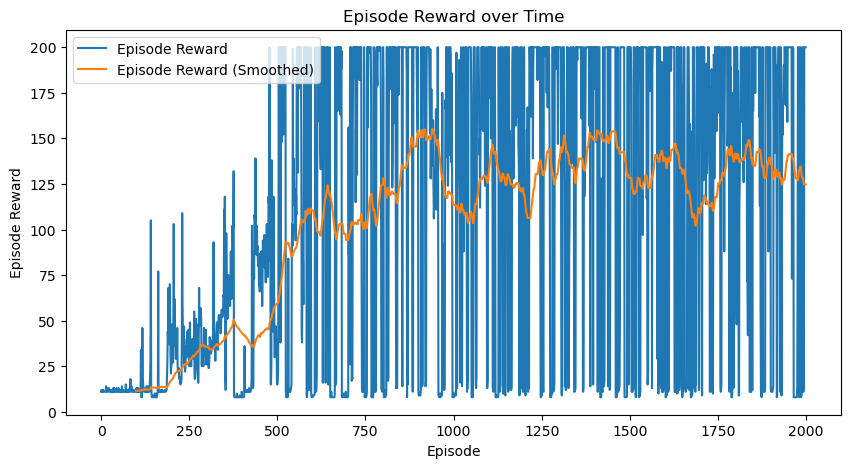

In [5]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 2000,
                        lr = 1e-3,
                        gamma = 0.9,
                        epsilon = 0.1,
                        seed = 0,
                        my_device = "cpu" # Use "cuda:?" if you want to use cuda. !! CPU is more efficient for these simple tasks 
                        )
    Manger.train()
    Manger.plotting() # The following curve is plotted used cuda